# AdaBoost 구현 설명

## 들어가기 전에

Kaggle 유저들 사이에서는 머신러닝 모델을 선택할 때 어떤 공식이 있는 거 같습니다. 마치 약속이라도 한 것처럼 Tabular 데이터면 거의 대부분 Tree-Boost 기반 모델을 사용하고, tabular가 아니면 대부분 NN 기반 모델을 사용합니다.  
이런 풍조가 맞나? 라는 의문이 들기도 하지만, 그 만큼 이 두 모델이 여러 분석에서 능력이 검증되었다는 방증이라고도 생각합니다. 

그래서 제가 저의 ML 패키지를 만들기로 마음 먹었을 때 첫 목표는 Boost 와 NN 을 구현하는 것이었습니다.  

이 노트북에서 설명하는 AdaBoost는 Boost 모델 중 제가 맨 처음 구현한 모델입니다. 


참고한 이론 관련 자료는 아래와 같습니다.  
- Statquest 의 AdaBoost 설명 영상 ([링크](https://youtu.be/LsK-xG1cLYA))
- 서울대 이상화 교수님의 AdaBoost 강의 (외부 프로그램에서 특강 형식으로 들어서 자료가 없습니다. 😥)
  
참고한 코드 관련 자료는 없습니다. 그래서 더 뿌듯하기도 합니다. ☺️

## class AdaStump 구현

### AdaBoost의 핵심


 
  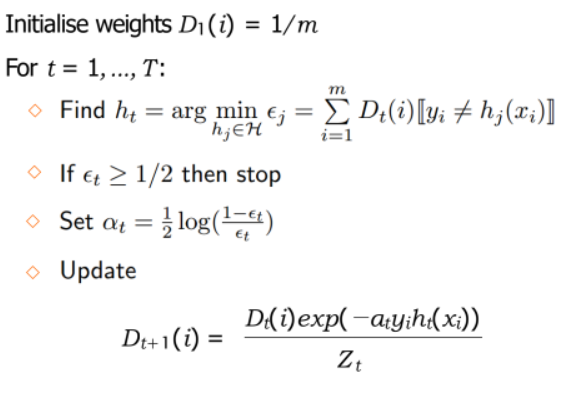

AdaBoost의 학습은 weak classifier로 분류를 수행하고, 분류가 제대로 안 된 샘플에 강한 가중치를 부여하여 다음 weak classifier를 학습시키는 과정을 반복하면서 이뤄집니다. 그리고 최종적으로 각 classifier에 가중치를 붙여 결과를 예측합니다.

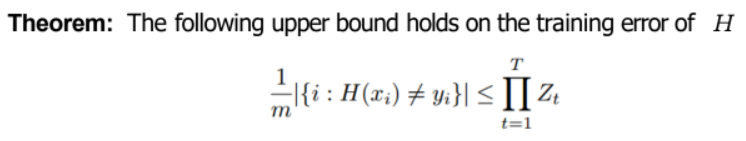

이론적으로 중요한 사실은 이 AdaBoost의 Error가 Upper bound를 가진다는 점입니다. 이건 학술적으로 중요한 사실입니다. 그러나 코드 구현 과정에서는 그렇게 중요하진 않습니다.  


이 노트북에서는 이론적인 내용보다는 제가 어떤 생각으로 ML을 구현했는지를 다룹니다. 혹시 이론적인 내용이 궁금하시다면, 위의 이론 관련 자료를 보시는 걸 추천드립니다.  
  
만약 본인이 ML의 전반적인 이론이 궁금하시다면, 
- [카이스트 문일철 교수님의 인공지능 및 기계학습 개론](https://kooc.kaist.ac.kr/machinelearning1_17)
- [부산대 김충락 교수님의 AI 연구자를 위한 통계적 학습론](http://www.kmooc.kr/courses/course-v1:PNUk+SL_C01+2021_KM_015/about)  

이 두 강의를 정말 추천드립니다. 저 또한 이 두 강의를 통해서 공부를 했고, 정말 많은 지식을 배울 수 있었습니다. 

### Stump는 최대한 추상적(Abstract)으로 정의




AdaBoost는 보통 depth가 1인 Tree(-> Stump)를 통해서 구현되는 것 같습니다. 그러나 Stump 자체는 그냥 이진분류기와 동치이기 때문에 최대한 다양한 classifier를 사용할 수 있도록 추상적이게 정의를 했습니다.  

예를 들어 선형분류인 SLP를 넣어서 AdaBoost를 구성할 수 있고, 복잡한 MLP를 넣어서 AdaBoost를 구성할 수도 있게 하고 싶었습니다. 또한, 여러 Classifier를 번갈아가면서 사용하는 것도 가능하게 하고 싶었습니다. 이게 더 재밌을 거 같았습니다. 😀  

그래서 최종적으로 제가 만든 AdaBoost는 아래와 같이 리스트를 인자로 받게 설계했습니다.  


```
model = AdaBoost([SLP, MLP])

model.compile(loss = 'mae', metrics = ['accuracy'], validation_split=0.2, verbose = 1, n_estimators = 20)
model.fit(x_train_n, y_train_n)
```

### 가중치 부여시 조심해야 할 점

AdaBoost의 원리상 분류가 잘 되는 샘플들의 가중치는 점점 더 작아지다가 0에 근사하게 됩니다. 문제는 가중치가 0에 너무 가까워지면 NAN 값으로 처리가 된다는 점입니다. NAN 값을 처리해주지 않으면, 이후에 나오는 모든 가중치들이 전부 NAN으로 처리가 됩니다.  

따라서 NAN 값이 나올 정도로 작은 값은 0으로 치환해주는 것이 좋습니다.

### 구현 코드

In [1]:
!pip install rosnet

In [2]:
import numpy as np

from rosnet.decorator import check_vector # 입력되는 값이 벡터가 아니면 벡터로 바꿔주는 decorator입니다.

class AdaStump:
  def __init__(self, classifier):
    self.classifier_ = classifier
  
  def fit(self, x, y, w = None):
    # fitting 하고 predict하고 가중치 계산해서 가중치를 반환하는 함수입니다.
    if len(y.shape) == 1:
      y = y.reshape(-1,1)
        
    if w is None:
      #y가 너무 많으면 이거 0로 처리될 수도 있음
      self.w_input = np.ones(y.shape)/len(y)
      self.history_ = self.classifier_.fit(x, y)
      self.y_predict = self.classifier_.predict(x)
    else:
      # 여기서 뭘 해야 하냐면
      # 가중치까지 집어 넣어서 분류기의 파라미터를 피팅해야 한다.
      # 이거 모델 수정해서 w도 포함하도록 해야 겠는데
      if len(w.shape) == 1 :
        w = w.reshape(-1,1)
      self.w_input = w
      self.history_ = self.classifier_.fit(x, y, weights = w)
      self.y_predict = self.classifier_.predict(x)

      self.get_weight(self.y_predict, y)

      return self.w_output
  
  def predict(self, x):
    result = self.classifier_.predict(x)
    if len(result) == 1:
      result = result.reshape(-1,1)
    return result

  @check_vector
  def get_weight(self, y_predict, y):
    # 이 부분은 NN 코드를 재활용 했습니다.
    est_yes = np.greater(y_predict, 0.5)
    ans_yes = np.greater(y, 0.5)
    est_no = np.logical_not(est_yes)
    ans_no = np.logical_not(ans_yes)

    tp = np.logical_and(est_yes, ans_yes)
    fp = np.logical_and(est_yes, ans_no)
    fn = np.logical_and(est_no, ans_yes)
    tn = np.logical_and(est_no, ans_no)

    correct = np.logical_or(tp, fn)
    incorrect = np.logical_or(tn, fp)

    # 에러를 통해 해당 Stump의 가중치를 결정합니다.
    self.tot_error_ = np.sum(incorrect * self.w_input)  
    self.amount_of_say_ = self.safe_div(1 - self.tot_error_, self.tot_error_)   
    self.amount_of_say_ = np.log(self.amount_of_say_) / 2 

    # Stump의 가중치로 분류가 안 된 샘플에 가중치를 부여합니다.
    self.w_output = self.w_input
    self.w_output[incorrect] = self.w_output[incorrect] * np.exp(self.amount_of_say_)
    self.w_output[correct] = self.w_output[correct] * np.exp(-self.amount_of_say_)

    # 너무 값이 낮아지면 nan이 되기 때문에 이를 0으로 바꿔줘야 오류가 나지 않습니다.
    condition = np.isnan(self.w_output)
    self.w_output[condition] = 0

    self.w_output = self.w_output / np.sum(self.w_output)

  def safe_div(self, p, q):
    # 이 부분은 NN 코드를 재활용 했습니다.
    p, q = float(p), float(q)
    if np.abs(q) < 1.0e-20: return np.sign(p)
    return p / q
  

## class AdaBoost 구현

### 오히려 AdaBoost 자체는 구현하기 쉬움

이미 필요한 함수들은 앞에서 다 정의를 했기 때문에 AdaBoost는 각 Stump들이 잘 작동할 수 있도록 연결만 해주면 됩니다.  

앞서 말씀드린 것처럼 리스트로 classifier를 입력 받도록 설계했습니다. 이 인자 입력 방식이 Keras의 그것과 유사하다고 느꼈습니다. 그래서 compile 방식도 keras의 그것과 유사한 구조로 설계했습니다.

### 과적합 방지를 위한 n_estimators 인자

AdaBoost는 Tree 기반 모델이라서 과적합이 되기 매우 쉽습니다. 따라서 Tree 모델에 depth 제한을 두는 것처럼 Stump 숫자에 제한을 걸어야 합니다. 이를 담당하는 인자가 ```n_estimators``` 입니다.  

또한 불필요한 시간 낭비를 줄이기 위해 Perfect fit이 나면 자동으로 종료되도록 설계했습니다.

### Shuffle을 조심해서 해야 함

보통 ML 기법에서는 초기값의 영향을 줄이기 위해 Shuffle을 하고 분석을 시작하도록 되어 있습니다.  

그러나 AdaBoost의 경우, 가중치를 계속 업데이트해야 하기 때문에 Shuffle 타이밍이 이상해지면 가중치가 엉뚱한 샘플에 갈 가능성이 있습니다. 그리고 이는 코드를 정지시키진 않기 때문에 문제가 생겨도 파악을 하기 힘듭니다.  

따라서 Shuffle을 할 때는 조심해서 해야 합니다.

### 구현 코드

In [3]:
import numpy as np

from rosnet.metrics import get_metrics # metircs 클래스를 이름으로 불러올 수 있게 하는 함수입니다.
from rosnet.util import train_test_split # 데이터를 Validation을 할 수 있게 나누는 함수입니다.

class AdaBoost:
  def __init__(self, classifiers):
    self.classifiers_ = classifiers
    self.estimators_ = []
  
  def compile(self, loss, metrics, n_estimators = 50, verbose=1, validation_split=0.0, early_stop = None, is_shuffle = False):
    
    self.metrics_ = {}

    if type(loss) == str:
      self.metrics_['loss'] = get_metrics(loss)()
      self.loss_ = get_metrics(loss)()

    else:
      self.loss_ = loss()
      self.metrics_['loss'] = loss()
    
    for key in metrics:
      if type(key) == str:
        self.metrics_[key] = get_metrics(key)()
      else:
        tmp = key()
        self.metrics_[str(tmp)] = tmp

    self.history_ = {}

    self.verbose_ = verbose
    self.validation_split_ = validation_split
    self.early_stop_ = early_stop
    self.is_shuffle_ = is_shuffle
    self.n_estimators_ = n_estimators
  
  def predict(self, x):
    result = np.zeros(x.shape[0]).reshape(-1,1)

    # 벡터 기반으로 작성했습니다. 
    # 나중에 공부를 더 하면 텐서 기반으로 작성하고 싶습니다.
    for estimator in self.estimators_:
      y_predict = estimator.predict(x)

      condition = y_predict > 0.5
      y_predict[condition] = 1 * estimator.amount_of_say_
      y_predict[~condition] = -1 * estimator.amount_of_say_

      result = result + y_predict
    
    result = np.greater(result, 0).astype(int)

    return result

  def fit(self, x, y, n_estimators = None, verbose=None, validation_split=None, early_stop = None, is_shuffle = None):
    
    if len(y.shape) == 1:
      y = y.reshape(-1,1)

    if verbose is None:
      verbose = self.verbose_
    if validation_split is None:
      validation_split = self.validation_split_
    if early_stop is None:
      early_stop = self.early_stop_
    if is_shuffle is None:
      is_shuffle = self.is_shuffle_
    if n_estimators is None:
      n_estimators = self.n_estimators_
    
    x_train, x_val, y_train, y_val = train_test_split(x, y, validation_split, is_shuffle)
    
    self.make_history()

    step = 0
    n_classifiers = len(self.classifiers_)
    #y가 대략 10억개 이상이면 0으로 처리될 수도 있습니다.
    w = np.ones(y.shape)/len(y)
    while step < n_estimators:
      self.make_metrics_per_step()

      stump = AdaStump(self.classifiers_[step % n_classifiers])
      self.estimators_.append(stump)
      w = self.estimators_[-1].fit(x, y, w)

      y_predict = self.predict(x)

      self.write_metrics_per_step(y_predict, y)
      self.write_history(x_val, y_val)
      
      if verbose > 0 and (step + 1)%verbose ==0:
        result = f"[Stump {step}] " + str([f"{key} = {self.history_[key][-1]:.3f}" for key in self.history_.keys()])
        print(result)     

      if self.history_['loss'][-1] == 0:
        break
      step += 1
    if verbose > 0 :
      print("\n[Final]" + str([f"{key} = {self.history_[key][-1]:.3f}" for key in self.history_.keys()]))

  def make_history(self):
    for key in self.metrics_.keys():
      if self.validation_split_ != 0.0: 
        self.history_['val_' + key] = []
      self.history_[key] = []

  def make_metrics_per_step(self):
    self.metrics_per_step = {}
    for key in self.metrics_.keys():
        self.metrics_per_step[key] = []

  def write_history(self, x_val, y_val):
      if len(y_val) != 0:
        y_predict = self.predict(x_val)
        for key in self.history_.keys():
          if key[:3] == 'val':
            met = self.metrics_[key[4:]].predict(y_predict, y_val)
            self.history_[key].append(met)
          else:
            met = self.metrics_per_step[key][-1]
            self.history_[key].append(met)
      else:
        for key in self.history_.keys():
          if key[:3] == 'val':
            continue
          else:
            met = self.metrics_per_step[key][-1]
            self.history_[key].append(met)
  
  def write_metrics_per_step(self, y_predict, y):
    for key in self.metrics_per_step.keys():
      met = self.metrics_[key].predict(y_predict, y)
      self.metrics_per_step[key].append(met)

  

  

## Sci-kit learn 과 성능 비교